
<img src="../images/5thNRST_logo.png" alt="NOWPAP" width="900" height="700">

## NOWPAP REMOTE SENSING TRAINING COURSE   
#### Webinar 2: Monitoring and Assessment of Water Quality by Ocean Color Remote Sensing

<hr style="border:2px solid rgb(30,70,125)"> </hr>

<span style="font-family:Helvieta; font-size:2em;">Eligio Maure (maure@npec.or.jp)</span>


# How to visualize data returned by the online matchup tool 

***

<div style="text-align: left"><i> 1.2 Working with swath imagery: Satellite Chlorophyll Validation </i></div>

***

***
**Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

# Table of contents
- [1. Purpose](#1.-Purpose)
- [2. Library import](#2.-Library-import)
- [3. Dataset](#3.-Dataset)
- [4. Parameter definition](#4.-Parameter-definition)
- [5. Data import](#5.-Data-import)
    - [5.1 Variables of interest in the data (exercise n.1)](#5.1-Variables-of-interest-in-the-data-(exercise-n.1))
    - [5.2 Exercise n.2 (with SGLI data)](#5.2-Exercise-n.2-(with-SGLI-data))
- [6. References](#6.-References)
***

# 1. Purpose
[Return to the "Table of contents"](#Table-of-contents)

The objective of this exercise is to visualize the satellite data product validation results obtained from the [Online Matchup Tool](https://ocean.nowpap3.go.jp/smat/) of the [Marine Environmental Watch](https://ocean.nowpap3.go.jp/?page_id=862) of Northwest Pacific Action Plan (NOWPAP).

In particular, we will display:
 
- the comparison of satellite-derived and in-situ chlorophyll (CHL) data.

The same exercise can be done for other satellite-derived geophysical values such as Remote Sensing Reflectance (Rrs), etc.
***


# 2. Library import
[Return to the "Table of contents"](#Table-of-contents) 

We import all the required Python libraries.    

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import string
from scipy import stats

# System
import sys
from pathlib import Path
from glob import glob

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

We include a local library from where we import our custom fuctions.  
To be able to do so, we append the path of where the custom functions are saved before importing.
***

In [10]:
sys.path.append(str(Path('.').absolute().parent)) 
import sutils as util

***
# 3. Dataset
[Back to the "Table of contents"](#Table-of-contents)

Two examples using MODIS-Aqua and SGLI/GCOM-C are given.  
1. MODIS-Aqua derived CHL -> [NOMAD: NASA bio-Optical Marine Algorithm Dataset](https://seabass.gsfc.nasa.gov/wiki/NOMAD).  

2. SGLI/GCOM-C CHL -> [in-situ CHL data](https://ocean.nowpap3.go.jp/?page_id=2345#42_Survey_stations_and_observation_parameters) obtained from routine observations of the Northwest Pacific Region Environmental Cooperation Center ([NPEC](http://www.npec.or.jp/en/)) in Toyama Bay, Japan.
***

# 4. Parameter definition
[Back to the "Table of contents"](#Table-of-contents)   

Set all relevant parameters for our notebook. 

By convention, parameters are uppercase, while all the other variables follow Python's guidelines (lowercase).

In [4]:
INPUT_DIR = Path('sample_data').absolute()
OUTPUT_DIR = Path('outputs').absolute()

# MODIS-Aqua validation results
AQUA_FILE = [f for f in INPUT_DIR.glob('nomad_chlor_fluo*.matchup.csv')][0]

# SGLI validation results
SGLI_FILE = [f for f in INPUT_DIR.glob('toyama_bay_database.*.matchup.csv')][0]
AQUA_FILE, SGLI_FILE

(WindowsPath('C:/Users/Eligio/Documents/NPEC/2021/5th-NOWPAP-Training-Course-on-Remote-Sensing-Data-Analysis/02 Working with swath imagery/sample_data/nomad_chlor_fluo.2021-12-02T12-46-21-011443.matchup.csv'),
 WindowsPath('C:/Users/Eligio/Documents/NPEC/2021/5th-NOWPAP-Training-Course-on-Remote-Sensing-Data-Analysis/02 Working with swath imagery/sample_data/toyama_bay_database.2021-12-02T14-25-33-553738.matchup.csv'))

***
# 5. Data import
[Return to the "Table of contents"](#Table-of-contents)

Import data using [pandas](https://pandas.pydata.org/).
- Use pandas [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function to load the output from the [Online Matchup Tool](https://ocean.nowpap3.go.jp/smat/).  

- When reading the text file, skip header lines. 
- Using a text editor (e.g. [Notepad++](https://notepad-plus-plus.org/)) we can see the number of lines to skip.

In [5]:
aqua_df = pd.read_csv(AQUA_FILE, skiprows=14)
aqua_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 75 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cruise            1548 non-null   object 
 1   Year              1548 non-null   int64  
 2   Month             1548 non-null   int64  
 3   Day               1548 non-null   int64  
 4   Hour              1548 non-null   int64  
 5   Minute            1548 non-null   int64  
 6   Second            1548 non-null   int64  
 7   Lat               1548 non-null   float64
 8   Lon               1548 non-null   float64
 9   id                1548 non-null   float64
 10  etopo2            1548 non-null   float64
 11  chl               1548 non-null   float64
 12  Datetime          1548 non-null   object 
 13  Filename          1548 non-null   object 
 14  Variable [Units]  1548 non-null   object 
 15  StartDatetime     1548 non-null   object 
 16  EndDatetime       1548 non-null   object 


# 5.1 Variables of interest in the data (exercise n.1)
[Return to the "Table of contents"](#Table-of-contents)   

Define the variables of interest to be extracted from the data frame

In [6]:
# Variable names
xvar = 'chl' # from in-situ input
yvar = 'Median' # median of the output
var_field = 'Variable [Units]' # the field where we extract the satellite variable of interest
select_var = 'chlor_a [mg m^-3]' # the name of the satellite variable of interest

aqua_df[var_field]

0       chlor_a [mg m^-3]
1         Rrs_412 [sr^-1]
2         Rrs_443 [sr^-1]
3         Rrs_488 [sr^-1]
4         Rrs_531 [sr^-1]
              ...        
1543      Rrs_531 [sr^-1]
1544      Rrs_547 [sr^-1]
1545      Rrs_645 [sr^-1]
1546      Rrs_667 [sr^-1]
1547      Rrs_678 [sr^-1]
Name: Variable [Units], Length: 1548, dtype: object

We use `Pandas` indexing to select specific data.  
`isin` will check all variable name with `'chlor_a [mg m^-3]'` in them and return `True` or `False` depending on the result.

In [7]:
idx = aqua_df[var_field].isin([select_var])

`loc` selects data at specific rows and columns of our data frame

In [8]:
x = aqua_df.loc[idx, xvar]
y = aqua_df.loc[idx, yvar]
x, y

(0       0.38200
 9       0.26900
 18      0.14400
 27      0.14400
 36      0.04700
          ...   
 1503    2.54190
 1512    2.95997
 1521    0.95114
 1530    4.54228
 1539    5.80693
 Name: chl, Length: 172, dtype: float64,
 0       0.189312
 9       0.157163
 18      0.124930
 27      0.140566
 36      0.056998
           ...   
 1503    4.867412
 1512    2.071994
 1521    0.858682
 1530    1.390481
 1539    2.334020
 Name: Median, Length: 172, dtype: float64)

Let's display the results for MODIS-Aqua

NameError: name 'util' is not defined

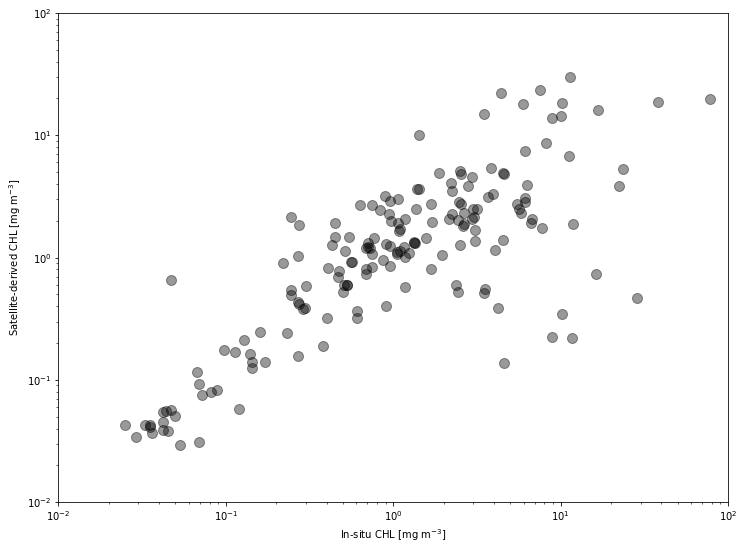

In [9]:
# initialise matplotlib figure
fig, ax = plt.subplots(figsize=(12,9))

# Display scatter
s = 100
ax.scatter(
    x, y,
    c='k',
    marker='o',
    alpha=0.4,
    s=s,
)

# Set axis labels
ax.set_xlabel('In-situ CHL [mg m$^{-3}$]')
ax.set_ylabel(f'Satellite-derived CHL [mg m$^{{-3}}$]')

# Set the scale to log
ax.set_xscale('log')
ax.set_yscale('log')

# Set axis limits
ax.set_xlim([0.01, 100])
ax.set_ylim([0.01, 100])

# Identity line
util.identity_line(ax=ax, lines=[1, 2, 3])

# Configure ticks
util.logticks(ax=ax, n=2)
            
# overestimate
xov, yov = util.overestimated(x=x.to_numpy(),
                              y=y.to_numpy(), 
                              ratio=3)
ax.scatter(xov, yov, s=s, c='r', marker='o', alpha=0.5) 

# underestimate
xun, yun = util.underestimated(x=x.to_numpy(),
                               y=y.to_numpy(), 
                               ratio=3)
ax.scatter(xun, yun, s=s, c='b', marker='o', alpha=0.5)
    
# Regression line
mask = np.isnan(x.to_numpy()) | np.isnan(y.to_numpy())
result = util.regress(x=x.to_numpy()[~mask].flatten(),
                      y=y.to_numpy()[~mask].flatten(), 
                      scale='log-log')
rl = ax.plot(result.xp, result.yp, '-g', label='linear regression', lw=6)

plt.legend(loc='lower right')
ax.text(.015, 3, result.desc)

# plt.title('0 m', loc='left')
plt.tight_layout()
day = datetime.today().strftime('%Y%m%d')
plt.savefig(OUTPUT_DIR.joinpath(f'{day}_modis_aqua_validation'), dpi=200)

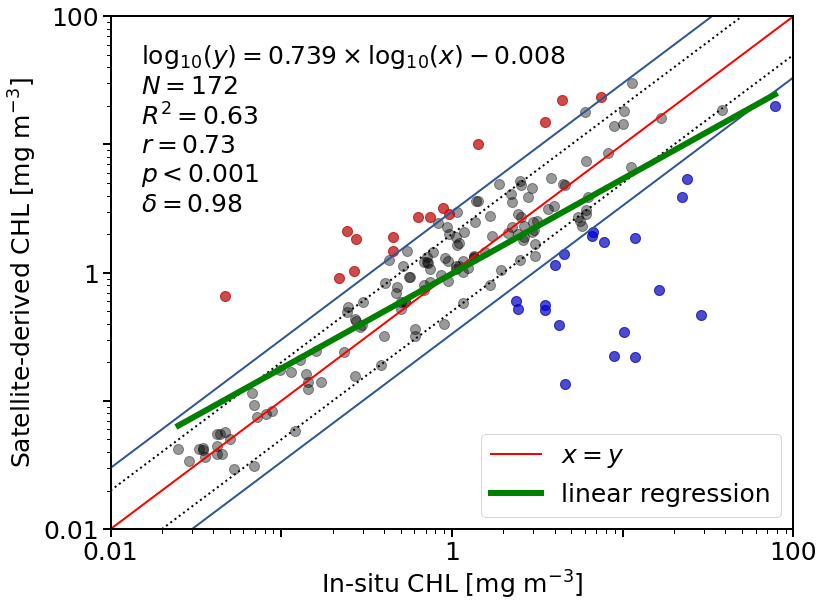

<div class="alert alert-block alert-warning" \div><br\>
   
# 5.2 Exercise n.2 (with SGLI data) (try it 5 min)

[Return to the "Table of contents"](#Table-of-contents)   

We can wrap the ploting into a function and then repeat the same exercise with SGLI data.  
Such function has been defined in `sutils`, just call `util.validation(params)`

In [ ]:
sgli_df = pd.read_csv(SGLI_FILE, skiprows=14)
sgli_df.info()

In [ ]:
# Variable names
xvar = 'Chla$_{(0.5+2)}$ [mg m$^{-3}$]'
yvar = 'Median'
select_var = 'CHLA [mg m^-3]'

idx = sgli_df[var_field].isin([select_var])

x = sgli_df.loc[idx, xvar]
y = sgli_df.loc[idx, yvar]

util.validation(x=x, y=y,
                xlabel='In-situ CHL [mg m$^{-3}$]', 
                ylabel=f'Satellite-derived CHL [mg m$^{{-3}}$]',
                plt=plt,
                figure_name=OUTPUT_DIR.joinpath(f'{day}_sgli_gcomc_validation'))
x, y

<div class="alert alert-block alert-success"/div>
    <b>Done!</b><br>
  
--- 

#### And thank you for your attention! :) 
    We hope you enjoyed the training provided by the Northwest Pacific Action Plan.

# 6. Resources
[Go back to the "Table of contents"](#Table-of-contents)
1. https://ocean.nowpap3.go.jp/smat/
2. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
3. https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
4. https://ocean.nowpap3.go.jp/?page_id=862
5. https://github.com/npec/5th-NOWPAP-Training-Course-on-Remote-Sensing-Data-Analysis